# Notebook to script running CosmoSIS

Regular imports first

In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from interpolate_cl import interp_cl
from functools import partial

Make CosmoSIS discoverable to Python and import it
(Have to install `future` package)

In [2]:
sys.path.append("/home/nbhandar/develop/cosmosis/")
from cosmosis.runtime.config import Inifile
from cosmosis.runtime.pipeline import LikelihoodPipeline
from cosmosis.output.in_memory_output import InMemoryOutput

## Auxilary Functions 

In [15]:
def get_c_ells_from_data_block(data):
    # get location of c_ell bins in data block
    # note this matches the order in Fisher_Forecaster.py
    # np.array([(i, j) for j in range(1, nbins+1) for i in range(1, j+1)])
    keys = []
    for k in data.keys():
        if k[0] == "shear_cl":
            if "bin_" in k[1][:4]:
                keys.append(k)
                
    # init array for c_ells
    ells = data["shear_cl", "ell"]
    shape = (len(ells), len(keys)+1)
    c_ells = np.zeros(shape)
    c_ells[:, 0] = ells
    
    # load in c_ells into array
    for i, k in enumerate(keys):
        c_ells[:, i+1] = data[k]

    return c_ells

In [3]:
"""This program predicts the theoretical covariance matrix
for LSS for each row in the input file


USES the cosmosis format

Author: MMRAU
"""

import sys
import numpy as np

 
def get_cov_matrix(l, data_order, cl_vals, orderings, fsky):
    """
    Return the covariance matrix
    Parameters:
    l: mode number
    data_order: order of the data vector
    cl_vals: numpy vector shotnoise already added for lookup purposes
    orderings: bin_ordering of the inputs for lookup purposes
    fsky: sky benefit
    number_density values: shot noise component
    """
    prefac = 1.0/(2.0*l + 1.0)/fsky
    out_cov = np.zeros((len(data_order), len(data_order)))
    for z in range(out_cov.shape[0]):
        for y in range(out_cov.shape[1]):
            i = data_order[z][0]
            j = data_order[z][1]
            k = data_order[y][0]
            l = data_order[y][1]

            try:
                cl_ik = cl_vals[orderings.index([i, k])]
            except ValueError:
                #this happens if only autocorrelation is queried
                cl_ik = 0.0

            try:
                cl_jl = cl_vals[orderings.index([j, l])]
            except ValueError:
                cl_jl = 0.0

            try:
                cl_il = cl_vals[orderings.index([i, l])]
            except ValueError:
                cl_il = 0.0

            try:
                cl_jk = cl_vals[orderings.index([j, k])]
            except ValueError:
                cl_jk = 0.0

            out_cov[z, y] = prefac * (cl_ik*cl_jl + cl_il*cl_jk)
    return out_cov

def multi_bin_cov(fsky, Clbins, Cl_ordering, num_dens): 
        #first column --> l values

    combination_cl = Clbins[:, 0]
    orderings = []
    for i in range(1, Clbins.shape[1]):
        #Cl_orderings has no l entry
        index_comb = Cl_ordering[i-1, :].tolist()
        if index_comb[0] != index_comb[1]:
            #add the entry plus the
            #reversed entry --> would NOT be valid for cross correlations since different
            #bins!!!
            combination_cl = np.column_stack((combination_cl, Clbins[:, i]))
            combination_cl = np.column_stack((combination_cl, Clbins[:, i]))
            orderings.append(index_comb)
            orderings.append([index_comb[1], index_comb[0]])
        else:
            #autocorrelations
            combination_cl = np.column_stack((combination_cl, Clbins[:, i]))
            orderings.append(index_comb)

    #remove the first column from combination_cl --> makes it easier since now
    #it corresponds to orderings vector

    combination_cl = combination_cl[:, 1:]

    assert len(orderings) == combination_cl.shape[1]

    #add the shotnoise to each of the cl combinations:
    # TODO: make this an option for clustering vs lensing
    shotnoise = []
    for el in orderings:
        shotnoise.append(1.0/num_dens[int(el[0] - 1)])  # because ordering starts with 1
    shotnoise = np.array(shotnoise)
    assert len(shotnoise) == combination_cl.shape[1]

    for i in range(combination_cl.shape[1]):
        #only the autocorrelation is affected by shot noise
        if orderings[i][0] == orderings[i][1]:
            combination_cl[:, i] += shotnoise[i]

    #now calculate the covariance matrice for each of the Cl_orderings
    out_mat = []
    for i in range(Clbins.shape[0]):
        curr_l = Clbins[i, 0]
        matrix_out = get_cov_matrix(curr_l, Cl_ordering, combination_cl[i, :], orderings, fsky)
        out_mat.append(matrix_out)
    return out_mat
        #np.savetxt(X=matrix_out, fname=out_filename+str(curr_l)+".mat")

def one_bin_cov(fsky, Clbins, num_dens): 
    added_shotnoise = (Clbins[:, 1] + 1.0/num_dens)**2
    prefactor = 2.0/((2.0 * Clbins[:, 0] + 1.)*fsky) 
    covariance = prefactor * added_shotnoise 
    cov_matrix = np.diag(covariance)
    return cov_matrix
    #np.savetxt(X=cov_matrix, fname=out_filename+"onebin.mat"

In [4]:
def get_para_index_from_pipeline(pipeline, para):
    i = 0 
    for p in pipeline.parameters:
        if para == p.name:
            return i
        i += 1
    print("Couldn't find para in pipeline")

In [5]:
def get_c_ells_changing_para(para_val,  para_name="", pipeline=None):
    # first check if parameter name is valid
    found_para = False
    for para_index, p in enumerate(pipeline.parameters):
        if para_name == p.name:
            found_para = True
            break
    if not found_para:
        print("Enter a valid parameter name, not", para_name)
        return
    
    print("Getting C_ells with", para_name, "= ", para_val)
    
    # store original parameter value for resetting later
    orig_para_val = pipeline.parameters[para_index].limits[0]
    
    # change parameter value and run pipeline to get c_ells
    delta = abs(orig_para_val - para_val)*2
    pipeline.set_varied("cosmological_parameters", para_name, orig_para_val - delta, orig_para_val + delta)
    data = pipeline.run_parameters([para_val])
    c_ells = get_c_ells_from_data_block(data)

    # restore original parameter value
    pipeline.set_fixed("cosmological_parameters", para_name, orig_para_val)
    print()
    return c_ells

In [6]:
def get_difference_coeffs(order):
    """ see https://en.wikipedia.org/wiki/Finite_difference_coefficient#Central_finite_difference

    Gets the finite difference coefficients for
    central first derivative upto accuracy O(h^order)

    Parameters:
    -----------
    order: int
        the order of the error; must be even and between 2 and 8
        defaults to 2 otherwise

    Returns:
    --------
    coeffs: dict
        keys are the prefactors of the step for each function call,
        and the values are the associated coefficients
    """

    if order == 2: #3 point stencil
        return {-1: -1./2, 0: 0, 1: 1./2}
    elif order == 4: #5 point stencil
        return {-2: 1./12, -1: -2./3, 0: 0, 1: 2./3, 2: -1./12}
    elif order == 6: #7 point stencil
        return {-3: -1./60, -2: 3./20, -1: -3./4, 0: 0, 1: 3./4, 2: -3./20, 3: 1./60}
    elif order == 8: # 9 point stencil
        return {-4: 1./280, -3: -4./105, -2: 1./5, -1: -4./5, 0: 0, 1: 4./5, 2: -1./5, 3: 4./105, 4: -1./280}
    else:  # default to 3 point stencil
        return {-1: -1./2, 0: 0, 1: 1./2}

In [7]:
def calc_para_deriv(pipeline, para, order, step_size, c_ell_funcs=None):
    print(para)
    if para == "wa":
        step = pipeline.parameters[get_para_index_from_pipeline(pipeline, "w")].limits[0] * step_size
    else:
        step = pipeline.parameters[get_para_index_from_pipeline(pipeline, para)].limits[0] * step_size
    coeffs = get_difference_coeffs(order)
    step_c_ells = dict()
    para_fid_val = pipeline.parameters[get_para_index_from_pipeline(pipeline, para)].limits[0]
    
    # for all possible finite difference coefficients,
    # we calculate a term in the approximation
    for step_mult in coeffs:
        coeff = coeffs[step_mult]
        if np.allclose(coeff, 0):
            # ignore if coefficient is 0
            continue
        
        # step the parameter we want to vary by the given step size
        para_val = para_fid_val + step_mult * step
        step_c_ells[step_mult] = c_ell_funcs[para](para_val)
        
    # now put the terms together to calculate the derivative
    deriv = None
    i = 0
    for step_mult in coeffs:
        coeff = coeffs[step_mult]
        if np.allclose(coeff, 0):
            continue # ignore case where coefficient is 0
        term = step_c_ells[step_mult]
        if i == 0:
            # init the derivative array
            deriv = np.zeros(term.shape)
            deriv[:, 0] = term[:, 0] # set the ell values
        deriv[:, 1:] += coeff * term[:, 1:]
        i += 1
    deriv[:, 1:] /= step
    
    return deriv

In [30]:
def get_fisher_mat(derivs, inv_covs):
    """ Calculates fisher matrix
    Params:
        derivs: 
            3 dimensional array containing del Cl/del para
            with shape (# params, # ells, # bins)
        inv_covs:
            3 dimensional array containing inverse data 
            covariance matrices with shape
            (# ells, # bins, # bins)
    Note: 
        Here # bins is referse how many auto and cross-correlations
        are there not photo-z bins
    """
    return np.einsum("ali,lij,blj->ab", derivs, inv_covs, derivs)

In [9]:
def get_fom_from_fisher(fisher, para_1, para_2, params):
    """Get Figure of Merit using Fisher matrix
    using para_1 and para_2
    """
    def marg_cov(cov, para_1, para_2, params):
        """marginalize a covariance matrix by deleting 
        all rows and columns except of the specified 
        parameters
        """
        ind1 = params.index(para_1)
        ind2 = params.index(para_2)
        inds = np.asarray((ind1, ind2))
        # first get all indeces to remove
        all_cov_inds = range(len(cov[0]))
        del_inds = np.delete(all_cov_inds, inds)
        # then delete rows and cols
        marged_cov = np.delete(np.delete(cov, del_inds, 0), del_inds, 1)
        return marged_cov
    
    def calc_fom_from_marged_cov(cov):
        """
        takes marg cov matrix
        inverts it to get reduced fisher matrix
        returns sqrt of det of fisher matrix
        """
        fisher = np.linalg.inv(cov)
        FOM = np.sqrt(np.linalg.det(fisher))
        return FOM
    
    cov = np.linalg.inv(fisher)
    marged_cov = marg_cov(cov, para_1, para_2, params)
    fom = calc_fom_from_marged_cov(marged_cov)
    return fom

## Set up
Create the configuration based on an ini file

In [10]:
ini = Inifile("cosmosis_scripting_files/run_cosmosis.ini") # use ini file as base
# ini.read("cosmosis_scripting_files/values.dat"); # read in values file containing cosmo param values

Make pipline from ini

In [11]:
pipeline = LikelihoodPipeline(ini)


Parameter Priors
----------------
cosmological_parameters--omega_c  ~ delta(0.25)
cosmological_parameters--h0       ~ delta(0.72)
cosmological_parameters--omega_b  ~ delta(0.04)
cosmological_parameters--tau      ~ delta(0.08)
cosmological_parameters--n_s      ~ delta(0.96)
cosmological_parameters--a_s      ~ delta(2.1e-09)
cosmological_parameters--w        ~ delta(-0.9)
cosmological_parameters--wa       ~ delta(0.0)
galaxy_bias--b                    ~ delta(1.0)





Found 5 samples and 300 bins in redshift in file /home/nbhandar/Fisher/tomo_lensing.dat

Calculating Limber: Kernel 1 = source, Kernel 2 = source, P_3D = matter_power_nl --> Output: 
Will project these spectra into 2D:
    -  shear_cl

Module timing:
consistency 0.001873
camb 0.001523
halofit 0.001137
extrapolate_power 0.001251
load_nz 0.018487
pk_to_cl 0.003330


In [12]:
data = pipeline.run_parameters([])

consistency took: 0.092 seconds
camb took: 18.727 seconds
halofit took: 0.731 seconds
extrapolate_power took: 0.085 seconds
load_nz took: 0.000 seconds
pk_to_cl took: 6.601 seconds
Total pipeline time: 26.2 seconds


In [16]:
c_ells = get_c_ells_from_data_block(data)

In [17]:
orderings = np.array([(i, j) for j in range(1, 5+1) for i in range(1, j+1)]) 

## Compare the C_ells to CCL

note the ells are not the same

In [100]:
ccl_c_ells = np.loadtxt("C_ell_fid_ccl.dat")

In [133]:
from interpolate_cl import interp_cl

In [135]:
c_ells_interp = interp_cl(c_ells, 76, 999)

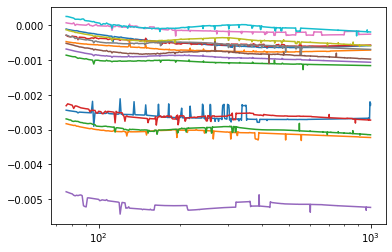

In [137]:
for i in range(len(c_ells_interp[0])-1):
    plt.semilogx(c_ells_interp[:, 0], (c_ells_interp[:, i+1]-ccl_c_ells[:, i+1])/ccl_c_ells[:, i+1])

## Make Cov Mats

In [18]:
numdens = np.loadtxt("num_dens_lensing.dat")
fsky = 0.48
cov_matrix_list = multi_bin_cov(fsky, c_ells, orderings, numdens)

In [19]:
inv_cov_list = [np.linalg.inv(c) for c in cov_matrix_list]

In [20]:
inv_cov_array = np.array(inv_cov_list)

## Get Derivatives:

First we make functions that we can call to get c_ells after changing a single parameter

In [21]:
get_c_ells_changing_omega_c = partial(get_c_ells_changing_para, pipeline=pipeline, para_name="omega_c")
get_c_ells_changing_w = partial(get_c_ells_changing_para, pipeline=pipeline, para_name="w")
get_c_ells_changing_h0 = partial(get_c_ells_changing_para, pipeline=pipeline, para_name="h0")
get_c_ells_changing_a_s = partial(get_c_ells_changing_para, pipeline=pipeline, para_name="a_s")
get_c_ells_changing_omega_b = partial(get_c_ells_changing_para, pipeline=pipeline, para_name="omega_b")
get_c_ells_changing_n_s = partial(get_c_ells_changing_para, pipeline=pipeline, para_name="n_s")
get_c_ells_changing_wa = partial(get_c_ells_changing_para, pipeline=pipeline, para_name="wa")
c_ell_of_para_dict = {
    "omega_c": get_c_ells_changing_omega_c,
    "w": get_c_ells_changing_w, 
    "h0": get_c_ells_changing_h0,
    "a_s": get_c_ells_changing_a_s,
    "omega_b": get_c_ells_changing_omega_b,
    "n_s": get_c_ells_changing_n_s,
    "wa": get_c_ells_changing_wa
}

In [22]:
derivs = dict()
deltas = {
    "omega_c": 0.1,
    "w": 0.1, 
    "h0": 0.04,
    "a_s": 0.05,
    "omega_b": 0.05,
    "n_s": 0.05,
    "wa": 0.08
}
for para in c_ell_of_para_dict:
    print(para)
    derivs[para] = calc_para_deriv(pipeline, para, 2, deltas[para], c_ell_of_para_dict)
    print()

omega_c
omega_c
Getting C_ells with omega_c =  0.225
consistency took: 0.001 seconds
camb took: 18.749 seconds
halofit took: 0.711 seconds
extrapolate_power took: 0.078 seconds
load_nz took: 0.000 seconds
pk_to_cl took: 6.213 seconds
Total pipeline time: 25.8 seconds

Getting C_ells with omega_c =  0.275
consistency took: 0.001 seconds
camb took: 19.107 seconds
halofit took: 0.722 seconds
extrapolate_power took: 0.021 seconds
load_nz took: 0.000 seconds
pk_to_cl took: 7.752 seconds
Total pipeline time: 27.6 seconds


w
w
Getting C_ells with w =  -0.81
consistency took: 0.001 seconds
camb took: 18.896 seconds
halofit took: 0.728 seconds
extrapolate_power took: 0.077 seconds
load_nz took: 0.000 seconds
pk_to_cl took: 6.539 seconds
Total pipeline time: 26.2 seconds

Getting C_ells with w =  -0.99
consistency took: 0.001 seconds
camb took: 18.707 seconds
halofit took: 0.711 seconds
extrapolate_power took: 0.076 seconds
load_nz took: 0.000 seconds
pk_to_cl took: 4.768 seconds
Total pipeline

In [23]:
derivs_array = np.zeros((len(derivs), *derivs['w'].shape))

In [24]:
for i, para in enumerate(derivs):
    derivs_array[i] = derivs[para]

In [25]:
derivs_array = derivs_array[:,:, 1:]

## Get Fisher Matrix

In [31]:
# F = np.einsum("ali,lij,blj->ab", derivs_array[:,:, 1:], inv_cov_array, derivs_array[:,:, 1:])
F = get_fisher_mat(derivs_array, inv_cov_array)

In [32]:
para_list = [p for p in c_ell_of_para_dict]
pd.DataFrame(F, columns=para_list, index=para_list)

,omega_c,w,h0,a_s,omega_b,n_s,wa
omega_c,1.144694e+07,-1.187242e+06,4.145515e+06,6.332683e+14,-6.085537e+06,8.822442e+05,-3.773137e+05
w,-1.187242e+06,1.256555e+05,-4.311946e+05,-6.647078e+13,6.348016e+05,-8.605446e+04,4.008838e+04
h0,4.145515e+06,-4.311946e+05,1.508825e+06,2.305587e+14,-2.232234e+06,3.211369e+05,-1.376895e+05
a_s,6.332683e+14,-6.647078e+13,2.305587e+14,3.547712e+22,-3.403735e+14,4.716476e+13,-2.126720e+13
omega_b,-6.085537e+06,6.348016e+05,-2.232234e+06,-3.403735e+14,3.356656e+06,-4.791041e+05,2.041295e+05
n_s,8.822442e+05,-8.605446e+04,3.211369e+05,4.716476e+13,-4.791041e+05,8.593906e+04,-2.721159e+04
wa,-3.773137e+05,4.008838e+04,-1.376895e+05,-2.126720e+13,2.041295e+05,-2.721159e+04,1.285822e+04


## Get FoM

In [33]:
w0_wa_fom = get_fom_from_fisher(F, "w", "wa", para_list)
om_m_A_s_fom = get_fom_from_fisher(F, "omega_c", "a_s", para_list)

In [34]:
print(w0_wa_fom)
print(om_m_A_s_fom)

36.074594392193106
259136276029.3107


## Now let's tune some derivatives

#### Parameter $\Omega_m$

In [29]:
tune_para = 'omega_c'

In [71]:
delta_start = 1e-3
delta_end = 3e-1
delta_num = 30
deltas_2 = np.logspace(np.log10(delta_start), np.log10(delta_end), delta_num)

In [72]:
om_c_2_fom_w0_wa = np.zeros(deltas_2.shape)
om_c_2_fom_om_m_A_s = np.zeros(deltas_2.shape)
tune_order = 2

In [73]:
# derivs = np.zeros((len(deltas), derivs[tune_para].shape))
# cl_steps = []

In [74]:
for i in range(len(deltas_2)):
    print("run %d/%d"%(i+1, delta_num))
    derivs[tune_para] = calc_para_deriv(pipeline, tune_para, tune_order, deltas_2[i], c_ell_of_para_dict)
    derivs_array[para_list.index(tune_para)] = derivs[tune_para][:, 1:]
    F = get_fisher_mat(derivs_array, inv_cov_array)
    om_c_2_fom_w0_wa[i] = get_fom_from_fisher(F, "w", "wa", para_list)
    om_c_2_fom_om_m_A_s[i] = get_fom_from_fisher(F, "omega_c", "a_s", para_list)

run 1/30
omega_c
Getting C_ells with omega_c =  0.24975
consistency took: 0.001 seconds
camb took: 18.615 seconds
halofit took: 0.721 seconds
extrapolate_power took: 0.076 seconds
load_nz took: 0.000 seconds
pk_to_cl took: 6.876 seconds
Total pipeline time: 26.3 seconds

Getting C_ells with omega_c =  0.25025
consistency took: 0.001 seconds
camb took: 18.653 seconds
halofit took: 0.699 seconds
extrapolate_power took: 0.076 seconds
load_nz took: 0.000 seconds
pk_to_cl took: 7.560 seconds
Total pipeline time: 27.0 seconds

run 2/30
omega_c
Getting C_ells with omega_c =  0.2496956607381244
consistency took: 0.001 seconds
camb took: 18.605 seconds
halofit took: 0.729 seconds
extrapolate_power took: 0.076 seconds
load_nz took: 0.000 seconds
pk_to_cl took: 6.837 seconds
Total pipeline time: 26.2 seconds

Getting C_ells with omega_c =  0.25030433926187556
consistency took: 0.001 seconds
camb took: 18.633 seconds
halofit took: 0.691 seconds
extrapolate_power took: 0.076 seconds
load_nz took: 0

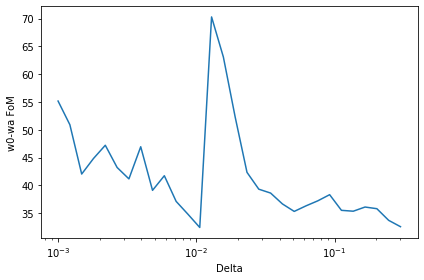

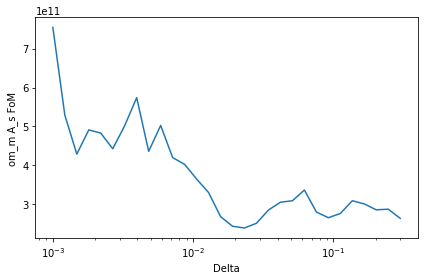

In [84]:
plt.semilogx(deltas_2, om_c_2_fom_w0_wa)
plt.xlabel("Delta")
plt.ylabel("w0-wa FoM")
# plt.ylim(top=45)
plt.tight_layout()
plt.show()
plt.semilogx(deltas_2, om_c_2_fom_om_m_A_s)
plt.xlabel("Delta")
plt.ylabel("om_m A_s FoM")
plt.tight_layout()
plt.show()

Pick 0.1 for $\Omega_m$

In [31]:
derivs[tune_para] = calc_para_deriv(pipeline, tune_para, 2, 0.1, c_ell_of_para_dict)
derivs_array[para_list.index(tune_para)] = derivs[tune_para][:, 1:]

omega_c
Getting C_ells with omega_c =  0.225
consistency took: 0.001 seconds
camb took: 18.595 seconds
halofit took: 0.698 seconds
extrapolate_power took: 0.076 seconds
load_nz took: 0.000 seconds
pk_to_cl took: 6.142 seconds
Total pipeline time: 25.5 seconds

Getting C_ells with omega_c =  0.275
consistency took: 0.001 seconds
camb took: 18.897 seconds
halofit took: 0.714 seconds
extrapolate_power took: 0.020 seconds
load_nz took: 0.000 seconds
pk_to_cl took: 7.597 seconds
Total pipeline time: 27.2 seconds



#### Parameter $w_0$

In [33]:
tune_para = 'w'
tune_order = 2

In [87]:
delta_start = 1e-3
delta_end = 3e-1
delta_num = 30
deltas_2 = np.logspace(np.log10(delta_start), np.log10(delta_end), delta_num)

In [88]:
w0_2_fom_w0_wa = np.zeros(deltas_2.shape)
w0_2_fom_om_m_A_s = np.zeros(deltas_2.shape)
tune_order = 2

In [89]:
for i in range(len(deltas_2)):
    print("run %d/%d"%(i+1, delta_num))
    derivs[tune_para] = calc_para_deriv(pipeline, tune_para, tune_order, deltas_2[i], c_ell_of_para_dict)
    derivs_array[para_list.index(tune_para)] = derivs[tune_para][:, 1:]
    F = get_fisher_mat(derivs_array, inv_cov_array)
    w0_2_fom_w0_wa[i] = get_fom_from_fisher(F, "w", "wa", para_list)
    w0_2_fom_om_m_A_s[i] = get_fom_from_fisher(F, "omega_c", "a_s", para_list)

run 1/30
w
Getting C_ells with w =  -0.8991
consistency took: 0.001 seconds
camb took: 18.548 seconds
halofit took: 0.722 seconds
extrapolate_power took: 0.076 seconds
load_nz took: 0.000 seconds
pk_to_cl took: 7.116 seconds
Total pipeline time: 26.5 seconds

Getting C_ells with w =  -0.9009
consistency took: 0.001 seconds
camb took: 18.759 seconds
halofit took: 0.716 seconds
extrapolate_power took: 0.076 seconds
load_nz took: 0.000 seconds
pk_to_cl took: 7.524 seconds
Total pipeline time: 27.1 seconds

run 2/30
w
Getting C_ells with w =  -0.8989043786572479
consistency took: 0.001 seconds
camb took: 18.499 seconds
halofit took: 0.722 seconds
extrapolate_power took: 0.076 seconds
load_nz took: 0.000 seconds
pk_to_cl took: 5.612 seconds
Total pipeline time: 24.9 seconds

Getting C_ells with w =  -0.9010956213427521
consistency took: 0.001 seconds
camb took: 18.532 seconds
halofit took: 0.723 seconds
extrapolate_power took: 0.076 seconds
load_nz took: 0.000 seconds
pk_to_cl took: 7.533 s

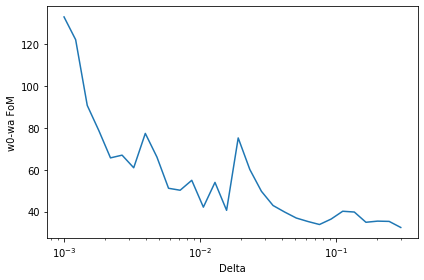

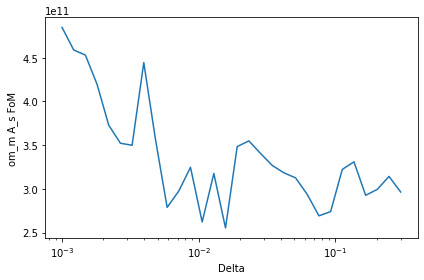

In [94]:
plt.semilogx(deltas_2, w0_2_fom_w0_wa)
plt.xlabel("Delta")
plt.ylabel("w0-wa FoM")
# plt.ylim(top=55)
plt.tight_layout()
plt.show()
plt.semilogx(deltas_2, w0_2_fom_om_m_A_s)
plt.xlabel("Delta")
plt.ylabel("om_m A_s FoM")
plt.tight_layout()
plt.show()

Pick 0.1 for $w_0$

In [34]:
derivs[tune_para] = calc_para_deriv(pipeline, tune_para, tune_order, 0.1, c_ell_of_para_dict)
derivs_array[para_list.index(tune_para)] = derivs[tune_para][:, 1:]

w
Getting C_ells with w =  -0.81
consistency took: 0.001 seconds
camb took: 18.533 seconds
halofit took: 0.722 seconds
extrapolate_power took: 0.076 seconds
load_nz took: 0.000 seconds
pk_to_cl took: 6.587 seconds
Total pipeline time: 25.9 seconds

Getting C_ells with w =  -0.99
consistency took: 0.001 seconds
camb took: 18.545 seconds
halofit took: 0.710 seconds
extrapolate_power took: 0.078 seconds
load_nz took: 0.000 seconds
pk_to_cl took: 4.727 seconds
Total pipeline time: 24.1 seconds



#### Parameter $h_0$

In [35]:
tune_para = 'h0'

In [97]:
delta_start = 1e-3
delta_end = 3e-1
delta_num = 30
deltas_2 = np.logspace(np.log10(delta_start), np.log10(delta_end), delta_num)

In [98]:
h0_2_fom_w0_wa = np.zeros(deltas_2.shape)
h0_2_fom_om_m_A_s = np.zeros(deltas_2.shape)
tune_order = 2

In [99]:
for i in range(len(deltas_2)):
    print("run %d/%d"%(i+1, delta_num))
    derivs[tune_para] = calc_para_deriv(pipeline, tune_para, tune_order, deltas_2[i], c_ell_of_para_dict)
    derivs_array[para_list.index(tune_para)] = derivs[tune_para][:, 1:]
    F = get_fisher_mat(derivs_array, inv_cov_array)
    h0_2_fom_w0_wa[i] = get_fom_from_fisher(F, "w", "wa", para_list)
    h0_2_fom_om_m_A_s[i] = get_fom_from_fisher(F, "omega_c", "a_s", para_list)

run 1/30
h0
Getting C_ells with h0 =  0.7192799999999999
consistency took: 0.001 seconds
camb took: 18.536 seconds
halofit took: 0.701 seconds
extrapolate_power took: 0.076 seconds
load_nz took: 0.000 seconds
pk_to_cl took: 6.319 seconds
Total pipeline time: 25.6 seconds

Getting C_ells with h0 =  0.72072
consistency took: 0.001 seconds
camb took: 18.491 seconds
halofit took: 0.682 seconds
extrapolate_power took: 0.076 seconds
load_nz took: 0.000 seconds
pk_to_cl took: 6.332 seconds
Total pipeline time: 25.6 seconds

run 2/30
h0
Getting C_ells with h0 =  0.7191235029257983
consistency took: 0.001 seconds
camb took: 18.502 seconds
halofit took: 0.704 seconds
extrapolate_power took: 0.076 seconds
load_nz took: 0.000 seconds
pk_to_cl took: 6.399 seconds
Total pipeline time: 25.7 seconds

Getting C_ells with h0 =  0.7208764970742016
consistency took: 0.001 seconds
camb took: 18.550 seconds
halofit took: 0.694 seconds
extrapolate_power took: 0.076 seconds
load_nz took: 0.000 seconds
pk_to_c

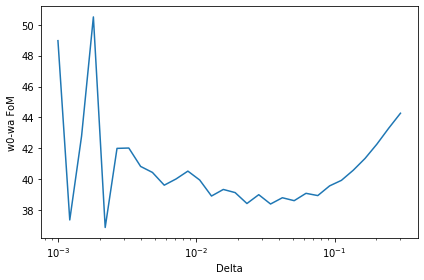

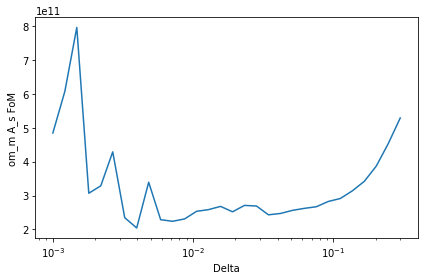

In [100]:
plt.semilogx(deltas_2, h0_2_fom_w0_wa)
plt.xlabel("Delta")
plt.ylabel("w0-wa FoM")
# plt.ylim(top=55)
plt.tight_layout()
plt.show()
plt.semilogx(deltas_2, h0_2_fom_om_m_A_s)
plt.xlabel("Delta")
plt.ylabel("om_m A_s FoM")
plt.tight_layout()
plt.show()

Pick 0.04 for $h_0$

In [36]:
derivs[tune_para] = calc_para_deriv(pipeline, tune_para, tune_order, 0.04, c_ell_of_para_dict)
derivs_array[para_list.index(tune_para)] = derivs[tune_para][:, 1:]

h0
Getting C_ells with h0 =  0.6911999999999999
consistency took: 0.001 seconds
camb took: 19.672 seconds
halofit took: 0.697 seconds
extrapolate_power took: 0.020 seconds
load_nz took: 0.000 seconds
pk_to_cl took: 7.373 seconds
Total pipeline time: 27.8 seconds

Getting C_ells with h0 =  0.7488
consistency took: 0.001 seconds
camb took: 17.894 seconds
halofit took: 0.717 seconds
extrapolate_power took: 0.076 seconds
load_nz took: 0.000 seconds
pk_to_cl took: 6.815 seconds
Total pipeline time: 25.5 seconds



#### Parameter $A_s$

In [37]:
tune_para = 'a_s'

In [103]:
delta_start = 1e-3
delta_end = 3e-1
delta_num = 30
deltas_2 = np.logspace(np.log10(delta_start), np.log10(delta_end), delta_num)

In [104]:
a_s_2_fom_w0_wa = np.zeros(deltas_2.shape)
a_s_2_fom_om_m_A_s = np.zeros(deltas_2.shape)
tune_order = 2

In [105]:
for i in range(len(deltas_2)):
    print("run %d/%d"%(i+1, delta_num))
    derivs[tune_para] = calc_para_deriv(pipeline, tune_para, tune_order, deltas_2[i], c_ell_of_para_dict)
    derivs_array[para_list.index(tune_para)] = derivs[tune_para][:, 1:]
    F = get_fisher_mat(derivs_array, inv_cov_array)
    a_s_2_fom_w0_wa[i] = get_fom_from_fisher(F, "w", "wa", para_list)
    a_s_2_fom_om_m_A_s[i] = get_fom_from_fisher(F, "omega_c", "a_s", para_list)

run 1/30
a_s
Getting C_ells with a_s =  2.0979000000000004e-09
consistency took: 0.001 seconds
camb took: 18.496 seconds
halofit took: 0.721 seconds
extrapolate_power took: 0.076 seconds
load_nz took: 0.000 seconds
pk_to_cl took: 6.376 seconds
Total pipeline time: 25.7 seconds

Getting C_ells with a_s =  2.1021e-09
consistency took: 0.001 seconds
camb took: 18.448 seconds
halofit took: 0.722 seconds
extrapolate_power took: 0.076 seconds
load_nz took: 0.000 seconds
pk_to_cl took: 6.393 seconds
Total pipeline time: 25.6 seconds

run 2/30
a_s
Getting C_ells with a_s =  2.097443550200245e-09
consistency took: 0.001 seconds
camb took: 18.455 seconds
halofit took: 0.725 seconds
extrapolate_power took: 0.077 seconds
load_nz took: 0.000 seconds
pk_to_cl took: 6.341 seconds
Total pipeline time: 25.6 seconds

Getting C_ells with a_s =  2.1025564497997552e-09
consistency took: 0.001 seconds
camb took: 18.450 seconds
halofit took: 0.708 seconds
extrapolate_power took: 0.076 seconds
load_nz took: 0

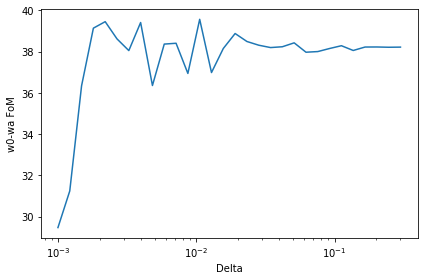

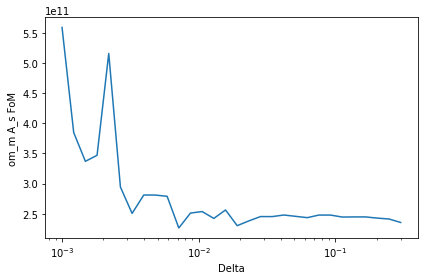

In [106]:
plt.semilogx(deltas_2, a_s_2_fom_w0_wa)
plt.xlabel("Delta")
plt.ylabel("w0-wa FoM")
# plt.ylim(top=55)
plt.tight_layout()
plt.show()
plt.semilogx(deltas_2, a_s_2_fom_om_m_A_s)
plt.xlabel("Delta")
plt.ylabel("om_m A_s FoM")
plt.tight_layout()
plt.show()

Pick 0.05 for $A_s$

In [38]:
derivs[tune_para] = calc_para_deriv(pipeline, tune_para, tune_order, 0.05, c_ell_of_para_dict)
derivs_array[para_list.index(tune_para)] = derivs[tune_para][:, 1:]

a_s
Getting C_ells with a_s =  1.9950000000000002e-09
consistency took: 0.001 seconds
camb took: 18.514 seconds
halofit took: 0.694 seconds
extrapolate_power took: 0.076 seconds
load_nz took: 0.000 seconds
pk_to_cl took: 6.352 seconds
Total pipeline time: 25.6 seconds

Getting C_ells with a_s =  2.205e-09
consistency took: 0.001 seconds
camb took: 18.450 seconds
halofit took: 0.727 seconds
extrapolate_power took: 0.076 seconds
load_nz took: 0.000 seconds
pk_to_cl took: 6.165 seconds
Total pipeline time: 25.4 seconds



#### Parameter $\Omega_b$

In [39]:
tune_para = 'omega_b'

In [109]:
delta_start = 1e-3
delta_end = 3e-1
delta_num = 30
deltas_2 = np.logspace(np.log10(delta_start), np.log10(delta_end), delta_num)

In [110]:
om_b_2_fom_w0_wa = np.zeros(deltas_2.shape)
om_b_2_fom_om_m_A_s = np.zeros(deltas_2.shape)
tune_order = 2

In [111]:
for i in range(len(deltas_2)):
    print("run %d/%d"%(i+1, delta_num))
    derivs[tune_para] = calc_para_deriv(pipeline, tune_para, tune_order, deltas_2[i], c_ell_of_para_dict)
    derivs_array[para_list.index(tune_para)] = derivs[tune_para][:, 1:]
    F = get_fisher_mat(derivs_array, inv_cov_array)
    om_b_2_fom_w0_wa[i] = get_fom_from_fisher(F, "w", "wa", para_list)
    om_b_2_fom_om_m_A_s[i] = get_fom_from_fisher(F, "omega_c", "a_s", para_list)

run 1/30
omega_b
Getting C_ells with omega_b =  0.03996
consistency took: 0.001 seconds
camb took: 18.592 seconds
halofit took: 0.721 seconds
extrapolate_power took: 0.076 seconds
load_nz took: 0.000 seconds
pk_to_cl took: 6.936 seconds
Total pipeline time: 26.3 seconds

Getting C_ells with omega_b =  0.04004
consistency took: 0.001 seconds
camb took: 18.623 seconds
halofit took: 0.719 seconds
extrapolate_power took: 0.076 seconds
load_nz took: 0.000 seconds
pk_to_cl took: 7.473 seconds
Total pipeline time: 26.9 seconds

run 2/30
omega_b
Getting C_ells with omega_b =  0.039951305718099905
consistency took: 0.001 seconds
camb took: 18.596 seconds
halofit took: 0.721 seconds
extrapolate_power took: 0.076 seconds
load_nz took: 0.000 seconds
pk_to_cl took: 6.952 seconds
Total pipeline time: 26.3 seconds

Getting C_ells with omega_b =  0.040048694281900096
consistency took: 0.001 seconds
camb took: 18.611 seconds
halofit took: 0.715 seconds
extrapolate_power took: 0.076 seconds
load_nz took

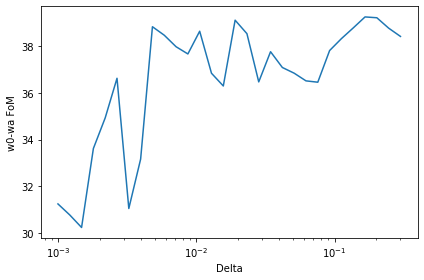

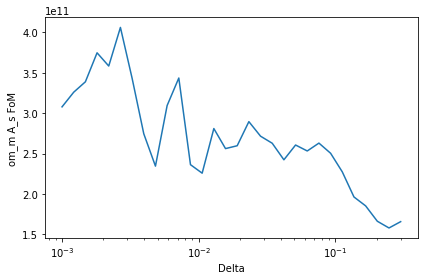

In [112]:
plt.semilogx(deltas_2, om_b_2_fom_w0_wa)
plt.xlabel("Delta")
plt.ylabel("w0-wa FoM")
# plt.ylim(top=55)
plt.tight_layout()
plt.show()
plt.semilogx(deltas_2, om_b_2_fom_om_m_A_s)
plt.xlabel("Delta")
plt.ylabel("om_m A_s FoM")
plt.tight_layout()
plt.show()

Pick 0.05 for $\Omega_b$

In [40]:
derivs[tune_para] = calc_para_deriv(pipeline, tune_para, tune_order, 0.05, c_ell_of_para_dict)
derivs_array[para_list.index(tune_para)] = derivs[tune_para][:, 1:]

omega_b
Getting C_ells with omega_b =  0.038
consistency took: 0.001 seconds
camb took: 19.499 seconds
halofit took: 0.684 seconds
extrapolate_power took: 0.020 seconds
load_nz took: 0.000 seconds
pk_to_cl took: 5.455 seconds
Total pipeline time: 25.7 seconds

Getting C_ells with omega_b =  0.042
consistency took: 0.001 seconds
camb took: 18.033 seconds
halofit took: 0.709 seconds
extrapolate_power took: 0.076 seconds
load_nz took: 0.000 seconds
pk_to_cl took: 6.430 seconds
Total pipeline time: 25.2 seconds



#### Parameter $n_s$

In [41]:
tune_para = 'n_s'

In [42]:
delta_start = 1e-3
delta_end = 3e-1
delta_num = 30
deltas_2 = np.logspace(np.log10(delta_start), np.log10(delta_end), delta_num)

In [43]:
n_s_2_fom_w0_wa = np.zeros(deltas_2.shape)
n_s_2_fom_om_m_A_s = np.zeros(deltas_2.shape)
tune_order = 2

In [44]:
for i in range(len(deltas_2)):
    print("run %d/%d"%(i+1, delta_num))
    derivs[tune_para] = calc_para_deriv(pipeline, tune_para, tune_order, deltas_2[i], c_ell_of_para_dict)
    derivs_array[para_list.index(tune_para)] = derivs[tune_para][:, 1:]
    F = get_fisher_mat(derivs_array, inv_cov_array)
    n_s_2_fom_w0_wa[i] = get_fom_from_fisher(F, "w", "wa", para_list)
    n_s_2_fom_om_m_A_s[i] = get_fom_from_fisher(F, "omega_c", "a_s", para_list)

run 1/30
n_s
Getting C_ells with n_s =  0.95904
consistency took: 0.001 seconds
camb took: 18.506 seconds
halofit took: 0.713 seconds
extrapolate_power took: 0.076 seconds
load_nz took: 0.000 seconds
pk_to_cl took: 6.398 seconds
Total pipeline time: 25.7 seconds

Getting C_ells with n_s =  0.9609599999999999
consistency took: 0.001 seconds
camb took: 18.456 seconds
halofit took: 0.686 seconds
extrapolate_power took: 0.076 seconds
load_nz took: 0.000 seconds
pk_to_cl took: 6.384 seconds
Total pipeline time: 25.6 seconds

run 2/30
n_s
Getting C_ells with n_s =  0.9588313372343977
consistency took: 0.001 seconds
camb took: 18.463 seconds
halofit took: 0.707 seconds
extrapolate_power took: 0.076 seconds
load_nz took: 0.000 seconds
pk_to_cl took: 6.408 seconds
Total pipeline time: 25.7 seconds

Getting C_ells with n_s =  0.9611686627656022
consistency took: 0.001 seconds
camb took: 18.454 seconds
halofit took: 0.678 seconds
extrapolate_power took: 0.077 seconds
load_nz took: 0.000 seconds
p

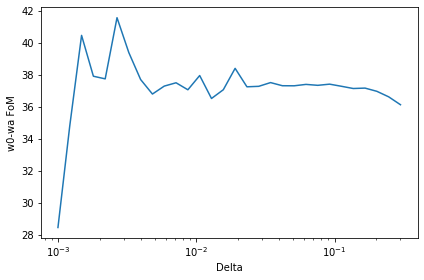

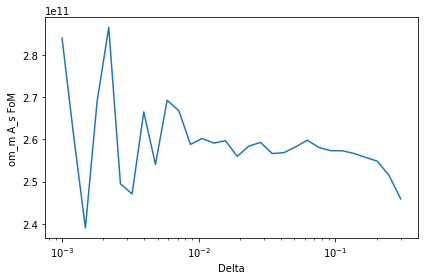

In [45]:
plt.semilogx(deltas_2, n_s_2_fom_w0_wa)
plt.xlabel("Delta")
plt.ylabel("w0-wa FoM")
# plt.ylim(top=55)
plt.tight_layout()
plt.show()
plt.semilogx(deltas_2, n_s_2_fom_om_m_A_s)
plt.xlabel("Delta")
plt.ylabel("om_m A_s FoM")
plt.tight_layout()
plt.show()

Pick 0.05 for $n_s$

In [46]:
derivs[tune_para] = calc_para_deriv(pipeline, tune_para, tune_order, 0.05, c_ell_of_para_dict)
derivs_array[para_list.index(tune_para)] = derivs[tune_para][:, 1:]

n_s
Getting C_ells with n_s =  0.9119999999999999
consistency took: 0.001 seconds
camb took: 18.458 seconds
halofit took: 0.706 seconds
extrapolate_power took: 0.076 seconds
load_nz took: 0.000 seconds
pk_to_cl took: 6.325 seconds
Total pipeline time: 25.6 seconds

Getting C_ells with n_s =  1.008
consistency took: 0.001 seconds
camb took: 18.454 seconds
halofit took: 0.689 seconds
extrapolate_power took: 0.076 seconds
load_nz took: 0.000 seconds
pk_to_cl took: 6.559 seconds
Total pipeline time: 25.8 seconds



#### Parameter $w_a$

In [47]:
tune_para = 'wa'

In [48]:
delta_start = 1e-3
delta_end = 3e-1
delta_num = 30
deltas_2 = np.logspace(np.log10(delta_start), np.log10(delta_end), delta_num)

In [49]:
wa_2_fom_w0_wa = np.zeros(deltas_2.shape)
wa_2_fom_om_m_A_s = np.zeros(deltas_2.shape)
tune_order = 2

In [50]:
for i in range(len(deltas_2)):
    print("run %d/%d"%(i+1, delta_num))
    derivs[tune_para] = calc_para_deriv(pipeline, tune_para, tune_order, deltas_2[i], c_ell_of_para_dict)
    derivs_array[para_list.index(tune_para)] = derivs[tune_para][:, 1:]
    F = get_fisher_mat(derivs_array, inv_cov_array)
    wa_2_fom_w0_wa[i] = get_fom_from_fisher(F, "w", "wa", para_list)
    wa_2_fom_om_m_A_s[i] = get_fom_from_fisher(F, "omega_c", "a_s", para_list)

run 1/30
wa
Getting C_ells with wa =  0.0009000000000000001
consistency took: 0.001 seconds
camb took: 19.361 seconds
halofit took: 0.720 seconds
extrapolate_power took: 0.076 seconds
load_nz took: 0.000 seconds
pk_to_cl took: 6.682 seconds
Total pipeline time: 26.8 seconds

Getting C_ells with wa =  -0.0009000000000000001
consistency took: 0.001 seconds
camb took: 19.335 seconds
halofit took: 0.716 seconds
extrapolate_power took: 0.076 seconds
load_nz took: 0.000 seconds
pk_to_cl took: 6.421 seconds
Total pipeline time: 26.5 seconds

run 2/30
wa
Getting C_ells with wa =  0.0010956213427521162
consistency took: 0.001 seconds
camb took: 19.354 seconds
halofit took: 0.720 seconds
extrapolate_power took: 0.077 seconds
load_nz took: 0.000 seconds
pk_to_cl took: 6.688 seconds
Total pipeline time: 26.8 seconds

Getting C_ells with wa =  -0.0010956213427521162
consistency took: 0.001 seconds
camb took: 19.371 seconds
halofit took: 0.716 seconds
extrapolate_power took: 0.076 seconds
load_nz to

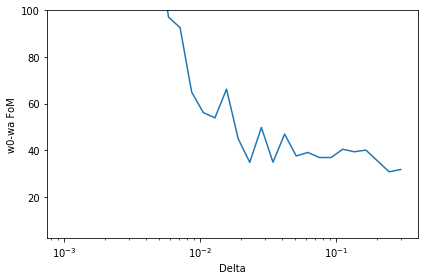

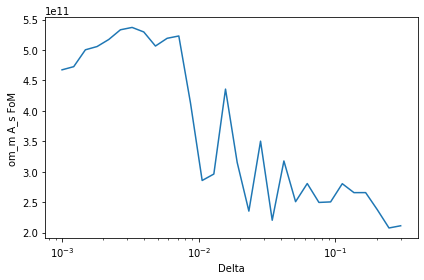

In [57]:
plt.semilogx(deltas_2, wa_2_fom_w0_wa)
plt.xlabel("Delta")
plt.ylabel("w0-wa FoM")
plt.ylim(top=100)
plt.tight_layout()
plt.show()
plt.semilogx(deltas_2, wa_2_fom_om_m_A_s)
plt.xlabel("Delta")
plt.ylabel("om_m A_s FoM")
plt.tight_layout()
plt.show()

Pick 0.08 for $w_a$

In [58]:
derivs[tune_para] = calc_para_deriv(pipeline, tune_para, tune_order, 0.08, c_ell_of_para_dict)
derivs_array[para_list.index(tune_para)] = derivs[tune_para][:, 1:]

wa
Getting C_ells with wa =  0.07200000000000001
consistency took: 0.001 seconds
camb took: 19.372 seconds
halofit took: 0.715 seconds
extrapolate_power took: 0.076 seconds
load_nz took: 0.000 seconds
pk_to_cl took: 8.359 seconds
Total pipeline time: 28.5 seconds

Getting C_ells with wa =  -0.07200000000000001
consistency took: 0.001 seconds
camb took: 19.319 seconds
halofit took: 0.690 seconds
extrapolate_power took: 0.077 seconds
load_nz took: 0.000 seconds
pk_to_cl took: 5.529 seconds
Total pipeline time: 25.6 seconds



## Get Fisher Matrix

In [59]:
# F = np.einsum("ali,lij,blj->ab", derivs_array[:,:, 1:], inv_cov_array, derivs_array[:,:, 1:])
F = get_fisher_mat(derivs_array, inv_cov_array)

In [60]:
para_list = [p for p in c_ell_of_para_dict]
pd.DataFrame(F, columns=para_list, index=para_list)

,omega_c,w,h0,a_s,omega_b,n_s,wa
omega_c,1.144694e+07,-1.187242e+06,4.145515e+06,6.332683e+14,-6.085537e+06,8.822442e+05,-3.773137e+05
w,-1.187242e+06,1.256555e+05,-4.311946e+05,-6.647078e+13,6.348016e+05,-8.605446e+04,4.008838e+04
h0,4.145515e+06,-4.311946e+05,1.508825e+06,2.305587e+14,-2.232234e+06,3.211369e+05,-1.376895e+05
a_s,6.332683e+14,-6.647078e+13,2.305587e+14,3.547712e+22,-3.403735e+14,4.716476e+13,-2.126720e+13
omega_b,-6.085537e+06,6.348016e+05,-2.232234e+06,-3.403735e+14,3.356656e+06,-4.791041e+05,2.041295e+05
n_s,8.822442e+05,-8.605446e+04,3.211369e+05,4.716476e+13,-4.791041e+05,8.593906e+04,-2.721159e+04
wa,-3.773137e+05,4.008838e+04,-1.376895e+05,-2.126720e+13,2.041295e+05,-2.721159e+04,1.285822e+04


## Get FoM

In [61]:
w0_wa_fom = get_fom_from_fisher(F, "w", "wa", para_list)
om_m_A_s_fom = get_fom_from_fisher(F, "omega_c", "a_s", para_list)

In [62]:
print(w0_wa_fom)
print(om_m_A_s_fom)

36.074594392193106
259136276029.3107


In [ ]:
F = get_fisher_mat()